In [2]:
import os
import glob
import json
import re
import string
from collections import Counter
def load_jsonl(jsonl_path):
    result = []

    with open(jsonl_path, 'r', encoding='utf-8') as f:
        result = [json.loads(line) for line in f]
    return result

In [4]:
datasets = ['hotpotqa', "musique", "2wikimqa"]
total_stat = {}
for dataset_name in datasets:
    merged_dataset = load_jsonl(f"/home/aiscuser/filter_question/data/{dataset_name}_train_merged_pred_dist_run_score.jsonl")
    cem_stats = {}
    f1_stats = {}
    for entry in merged_dataset:
        pred_list = entry['pred_list']
        avg_cem_score = sum([pred['cem_score'] for pred in pred_list]) / len(pred_list)
        total_cem_score = sum([pred['cem_score'] for pred in pred_list])
        avg_f1_score = sum([pred['f1_score'] for pred in pred_list]) / len(pred_list)

        high_f1_count = sum(1 for pred in pred_list if pred['f1_score'] > 0.75)


        entry['avg_cem_score'] = avg_cem_score
        entry['total_cem_score'] = total_cem_score
        entry['avg_f1_score'] = avg_f1_score
        entry["high_f1_count"] = high_f1_count
        # since we have 8 pred in pred_list
        # count how many pred list have a total cem score in 0,1,2,3,4,5,6,7,8 each
        if total_cem_score not in cem_stats:
            cem_stats[total_cem_score] = 0
        cem_stats[total_cem_score] += 1
        if high_f1_count not in f1_stats:
            f1_stats[high_f1_count] = 0
        f1_stats[high_f1_count] += 1
        # print(f"avg_cem_score: {avg_cem_score}, total_cem_score: {total_cem_score}, avg_f1_score: {avg_f1_score}, high_f1_count: {high_f1_count}")
    print(f"dataset_name: {dataset_name}")
    print(f"cem_stats: {cem_stats}")
    print(f"f1_stats: {f1_stats}")
    total_stat[dataset_name] = {
        "cem_stats": cem_stats,
        "f1_stats": f1_stats
    }

dataset_name: hotpotqa
cem_stats: {8.0: 42432, 1.0: 2519, 5.0: 3656, 2.0: 2068, 0: 11786, 4.0: 2734, 6.0: 6491, 7.0: 16561, 3.0: 2200}
f1_stats: {8: 43122, 1: 2464, 5: 3550, 2: 2028, 0: 11149, 4: 2696, 6: 6543, 7: 16806, 3: 2089}
dataset_name: musique
cem_stats: {0: 6736, 8.0: 4158, 3.0: 960, 6.0: 1264, 5.0: 1003, 7.0: 2056, 4.0: 930, 1.0: 1714, 2.0: 1117}
f1_stats: {0: 7200, 8: 4349, 3: 843, 6: 1180, 5: 932, 7: 1995, 4: 857, 2: 1029, 1: 1553}
dataset_name: 2wikimqa
cem_stats: {7.0: 35822, 6.0: 15764, 8.0: 79249, 5.0: 6630, 1.0: 2231, 0: 20798, 3.0: 2060, 4.0: 3258, 2.0: 1642}
f1_stats: {7: 35035, 6: 15799, 8: 80795, 5: 6835, 1: 2616, 0: 18414, 3: 2458, 4: 3491, 2: 2011}


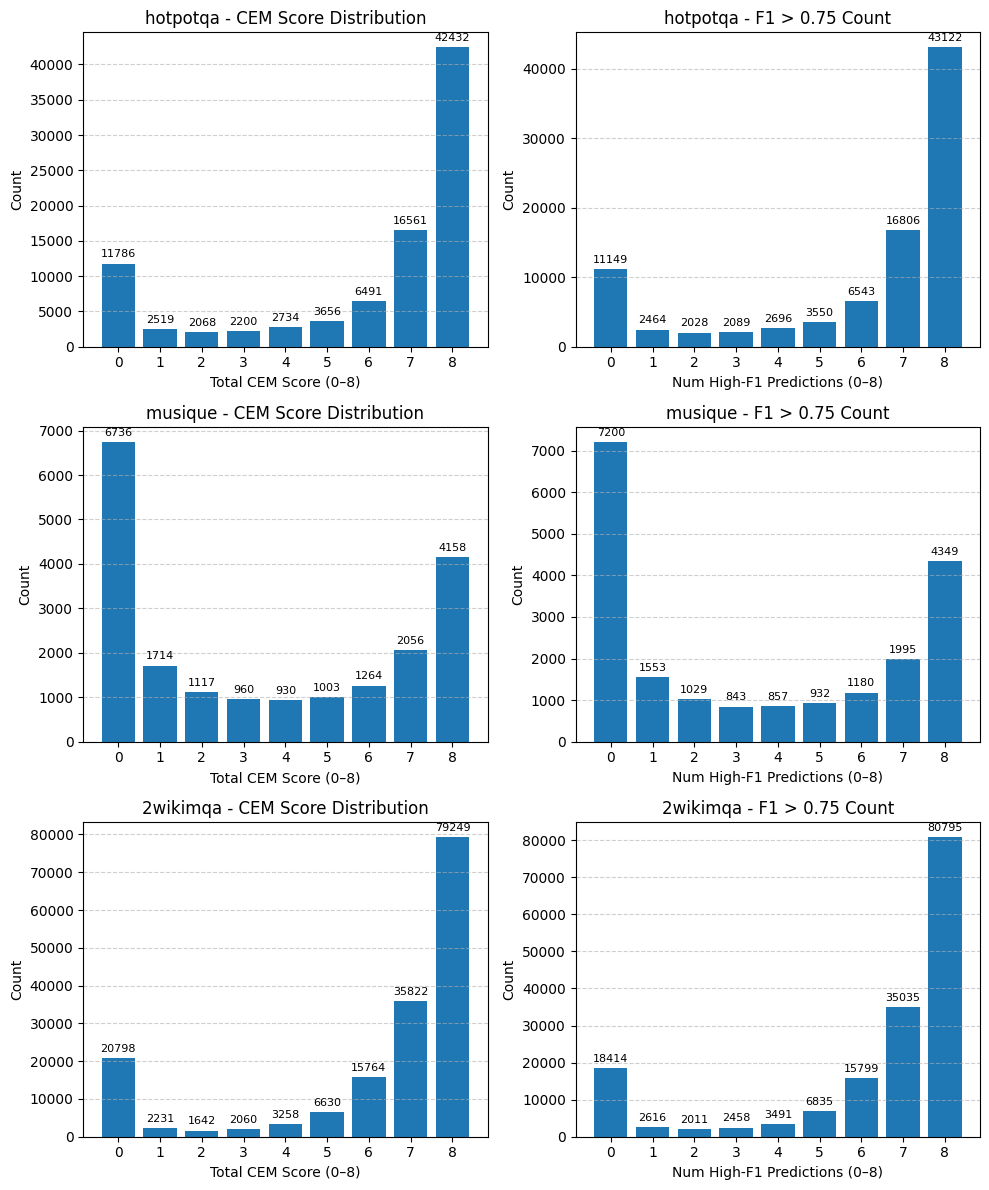

In [7]:
import matplotlib.pyplot as plt

# def plot_stat(ax, stat_dict, title, xlabel, ylabel):
#     keys = sorted(stat_dict.keys())
#     values = [stat_dict[k] for k in keys]
#     ax.bar(keys, values)
#     ax.set_title(title)
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.set_xticks(keys)
#     ax.grid(axis='y', linestyle='--', alpha=0.6)
def plot_stat(ax, stat_dict, title, xlabel, ylabel):
    keys = sorted(stat_dict.keys())
    values = [stat_dict[k] for k in keys]
    bars = ax.bar(keys, values)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(keys)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{int(height)}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=8
        )

# Number of datasets (for layout)
num_datasets = len(total_stat)

# Create subplots: 1 row per dataset, 2 columns (cem + f1)
fig, axs = plt.subplots(num_datasets, 2, figsize=(10, 4 * num_datasets))

if num_datasets == 1:
    axs = [axs]  # Wrap in a list for consistency

for row_idx, (dataset_name, stats) in enumerate(total_stat.items()):
    cem_stats = stats["cem_stats"]
    f1_stats = stats["f1_stats"]

    # Plot CEM stats
    plot_stat(
        axs[row_idx][0],
        cem_stats,
        title=f"{dataset_name} - CEM Score Distribution",
        xlabel="Total CEM Score (0–8)",
        ylabel="Count"
    )

    # Plot F1 stats
    plot_stat(
        axs[row_idx][1],
        f1_stats,
        title=f"{dataset_name} - F1 > 0.75 Count",
        xlabel="Num High-F1 Predictions (0–8)",
        ylabel="Count"
    )

plt.tight_layout()
plt.show()